<a href="https://colab.research.google.com/github/roshan-k-patel/APCOMP2090A-workbooks/blob/master/209a_sec01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science

## Section 1: Introduction to Web Scraping

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
**Preceptor**: Chris Gumb

<hr style='height:2px'>

In [ ]:
# Importing necessary libraries
# Python standard library
from collections import Counter, defaultdict
import html # for converting escaped characters in HTML content
import json # key-value data structure
import os
import re # regular expressions
import time
# 3rd party libraries
from bs4 import BeautifulSoup # HTML parsing
from IPython.display import HTML # render HTML in the notebook
import matplotlib.pyplot as plt # plotting library
import numpy as np
import pandas as pd # tabular data (Dataframes)
import requests # get/post HTML requests

## Table of Contents
- [Introduction---------------------------(3mins)](#Section-Learning-Objectives)
- [Getting HTML from the Web-----------(20mins)](#Getting-HTML-from-the-Web)
- [Regular Expressions-------------------(7mins)](#Regular-Expressions)
- [Parse the HTML with BeautifulSoup----(7mins)](#Parse-the-HTML-with-BeautifulSoup)
- [Extracting Award Data------------------(7mins)](#Extracting-award-data)
- [Asking Questions----------------------(20mins)](#Asking-Questions)
- [Visualization (Preview)-----------------(3mins)](#Visualization-(Preview))
- [Pandas DataFrame (Preview)-----------(3mins)](#Pandas-DataFrame-(preview))
- [Appendix-------------------------------(5mins)](#Appendix)

---

## Section Learning Objectives

When we're done today, you will approach messy, real-world data on the web with the confidence that you can get it into a format that you can use to answer your questions of interest.

Specifically, our learning objectives are:
* Getting HTML content from the web programmatically with [Requests](https://requests.readthedocs.io/en/latest/)
* Navigating the tree-like structure of an HTML document and using that structure to extract desired information with the help of [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* Wrangling, parsing, and storing information pulled from the web using regular expressions, lists, and dictionaries.

We'll also have a preview of:
* Creating visualizations with `matplotlib`
* Creating a tabular data object (`pandas` DataFrame) from parsed data and saving it as a comma separated values file (csv)


## Nobel Prize Website

The source of our data will be the offical site for the Nobel Prize,
https://www.nobelprize.org/.

Some questions we might want to answer:
- Who has been awarded more than one prize?
- How many unique prizes are there and has this always been the case?
- How have the number of recipients changed over time?
- Which prize has the fewest number of recipients?


## Getting HTML from the Web

If our end goal is to extract data from HTML documents, our first step is to acquire those HTML files from the web.\
We could of course visit a web page in our browser and save the page to disk. But that sort of tedious clicking is what we use programming to avoid!\
There are command line applications like [curl](https://curl.se/) which can be used to pull web data, and options like this can be worked into larger scripts or programming procects. But we're looking for something a bit more... Pythonic.

## Requests

"[Requests](https://requests.readthedocs.io/en/latest/) is an elegant and simple [HTTP](https://en.wikipedia.org/wiki/Hypertext_Transfer_Protocol) library for Python, built for human beings."

Its ease of use has made this 3rd party library a very popular option for pulling content from the web via the HTTP `GET` request. This is the request your browser sends to the webserver to view a webpage.

First, we'll need the target URL. Specifically, this will be the page that lists all prizes across all years.

In [ ]:
all_prizes_url = 'https://www.nobelprize.org/prizes/lists/all-nobel-prizes/all/'

Then we use the `requests.get` method to grab the content of that URL.\
The returned object is a `Response` which has some useful information beyond the website content. For example, the response status code.

In [ ]:
response = requests.get(all_prizes_url)

In [ ]:
response.status_code

200

Response [200] is a success status code. Let's google: [`response 200 meaning`](https://www.google.com/search?q=response+200+meaning&oq=response+%5B200%5D+m&aqs=chrome.1.69i57j0l5.6184j0j7&sourceid=chrome&ie=UTF-8). All possible codes and their meanings can be found [here](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status).

What if we accidentally make a get request for a page that doesn't exist?

In [ ]:
bogus_url = 'https://www.google.com/oops'
bogus_response = requests.get(bogus_url)
bogus_response.status_code

404

The dreaded "404 NOT FOUND" error! ☠️\
(JupyterHub users may see 403)

**HTML Content**

Now let's look at the HTML we just scraped which is contained in the `text` attribute of our original Request object which we called `response`.

In [ ]:
# peek at the HTML
response.text[:200]

'\t<!DOCTYPE html>\n\t<html lang="en-US" class="no-js">\n\t<head>\n\t\t<meta charset="UTF-8"><script type="text/javascript">(window.NREUM||(NREUM={})).init={privacy:{cookies_enabled:true},ajax:{deny_list:["bam'

In [ ]:
# stash it in a variable
html = response.text

Great! We now have the page's HTML data in a Python string.

## HTML

The first step in web scraping is to understand the HTML structure of the webpage.

HTML (**H**yper **T**ext **M**arkup **L**anguage), is the standard markup language for documents designed to be displayed in a web browser. It is often complemented by CSS for styling and JavaScript for dynamic, interactive content.

HTML describes the structure of a web page *semantically*. That is, describes not only the position of each element in the document's tree structure (e.g., 2nd child of tree's root), but also what each element *means* (title, level 2 header, paragraph, etc.).

### Standard HTML documents

HTML documents generally have the following structure:

\<!DOCTYPE html>

<html>

    <head>

        <title>Page Title</title>

    </head>

    <body>

        <h1>Page Heading</h1>

        <p>The first paragraph of page</p>

        ...
        ...
        ...

    </body>

\</html>

### What does each of these tags indicate?

- The **\<!DOCTYPE html>** declaration defines that this document is an HTML5 document

- The **\<html>** element is the root element of an HTML page

- The **\<head>** element contains meta information about the HTML page

- The **\<title>** element specifies a title for the HTML page (which is shown in the browser's title bar or in the page's tab)

- The **\<body>** element defines the document's body, and is a container for all the visible contents, such as headings, paragraphs, images, hyperlinks, tables, lists, etc.

- The **\<h1>** element defines a large heading. There are other heading tags in html, **\<h2>, \<h3>, \<h4>, \<h5>, \<h6>**

- The **\<p>** element defines a paragraph


### What is an HTML Element?

An HTML element is defined by a start tag, some content, and an end tag:

**\<tagname> Tag content \</tagname>**

An example of an HTML element is as follows:

**\<h1> The Page Heading \</h1>**



Let's take a look at the [Nobel Prizes across all years](https://www.nobelprize.org/prizes/lists/all-nobel-prizes/all/) and inspect the HTML under-the-hood: right-click on the page and select `inspect`.You should see something like this.
![20240906_02h56m43s_grim.png](attachment:b2472872-0fcc-419d-a890-ddcc533e753f.png)

### Mapping the HTML tags to the webpage

When you inspect, try to map each element on the webpage to its HTML.

![html2.png](attachment:ace6ff66-272d-4742-a12b-d9f1390dc1c2.png)

#### 🏋️ Exercise 1:

- Search the page to find the **blockquote** containing the following text:<br>
_“for his development of the Wilson cloud chamber method, and his discoveries therewith in the fields of nuclear physics and cosmic radiation”_<br>
- Identify the class attribute of this `<blockquote>` tag.
- Example answer format: `class="example-class-name"`

But how should we go about parsing and navigating all this text to find what we are interested in? You might be tempted to try...

## Regular Expressions

You can find specific patterns or strings in text by using Regular Expressions (often abbreviated "re", "regex", or "regexp"): This is a pattern matching mechanism used throughout Computer Science and programming (it's not just specific to Python).

Some great resources that we recommend, if you are interested in them (could be very useful for a homework problem):
- https://docs.python.org/3/howto/regex.html
- https://regexone.com (tutorial)
- https://regex101.com (testing patters)

Regular expressions use specific characters to stand for sets of characters or modifiers. A regex itself defines a set of strings which we call "matches."\
Some examples:
- ```\s``` : Matches any Unicode whitespace character: spaces, tabs, newlines
- ```\S``` : Matches any character which is **NOT** a Unicode whitespace character (note: capital 'S')
- ```\d``` : Matches any Unicode decimal digit, `0`, `1`, ..., `9`
- ```\w``` : Matches any "word" characters: letters, numbers, and underscores
- ```*``` : Causes the resulting RE to match 0 or more repetitions of the preceding RE, as many repetitions as are possible.
- ```+``` : Similar to `*` but matches 1 or more repetitions of prededing RE
- ```{n}```: Matches `n` occurances of the preceding RE. Ex: `b{3}` would match `'bbb'`

Python includes [re](https://docs.python.org/3.12/library/re.html) in its standard library. We can use its `find_all` method to find all substrings in a target string that match a regular expression of our devising.

**Let's find all the occurances of 'Marie' in our raw_html:**

In [ ]:
re.findall(r'Marie', html)

['Marie', 'Marie', 'Marie', 'Marie']

**Now use ```\S``` to match 'Marie' + ' ' + 'any character which is not a Unicode whitespace character':**

In [ ]:
re.findall(r'Marie \S', html)

['Marie G', 'Marie L', 'Marie C', 'Marie C']

**🤔 Q: How would we find the lastnames that come after Marie?**


In [ ]:
last_names = re.findall(r'Marie \w*', html)
display(last_names)

['Marie Gustave', 'Marie Lehn', 'Marie Curie', 'Marie Curie']

This is an example of code that is *intended* to grab the h3 header containing an anchor (link) tag with non-empty text content.

In [ ]:
first_title = re.findall(r"<h3>\s*<a[^>]*>(.+?)</a>\s*</h3>", html, re.DOTALL)[0]
print(first_title)


			Nobel Prize in Physics 2024		


It seems to work in this particular situation. But regex can quickly become quite long and obtuse, and while they can prove useful in many scenarios (like those in HW0!), it is ill-advised to use them to parse HTML tags. This is because regexs are not sufficiently complex to capture all possible HTML structures. If you're curious you can read about the distinctions between [Regular Grammars](https://en.wikipedia.org/wiki/Regular_grammar) (regex) and [Context-free Grammars](https://en.wikipedia.org/wiki/Context-free_grammar) (HTML).

## Parse the HTML with BeautifulSoup

"[BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/) is a Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree. It commonly saves programmers hours or days of work."

BeautifulSoup works by parsing the raw html text into a tree. Every tag in the raw html becomes a node in the tree. We can then navigate the tree by selecting a node and querying its parent, children, siblings, etc.

![html-dom.png](attachment:5ab1c47c-976a-428f-8e57-c21cef6afa8b.png)

In [ ]:
soup = BeautifulSoup(html)

Key BeautifulSoup functions we’ll be using in this section:

**Visually Inspecting**
- **`tag.prettify()`**: Returns cleaned-up version of raw HTML, useful for printing

**Searching**
- **`tag.select(selector)`**: Return a list of nodes matching a [CSS selector](https://developer.mozilla.org/en-US/docs/Learn/CSS/Introduction_to_CSS/Simple_selectors)
- **`tag.select_one(selector)`**: Return the first node matching a CSS selector
- **`tag.text`/`soup.get_text()`**: Returns visible text of a node (e.g.,"`<p>Some text</p>`" -> "Some text")
- **`tag.contents`**: A list of the immediate children of this node

You can also use these functions to find nodes.
- **`tag.find_all(tag_name, attrs=attributes_dict)`**: Returns a list of matching nodes
- **`tag.find(tag_name, attrs=attributes_dict)`**: Returns first matching node

You are not limit to searching for tags. You can also search for text, even using regular expressions!:
- **`tag.find("div", string="Text of Interest")`**: Returns the first `div` tag who `text` content is "Text of Interest"
- **`tag.find("a", string=re.compile(r"\d+"))`**: Returns the first `a` tag who `text` content is one or more digits

Or you can move about the tree using relative position:

**Going Down**
- **`tag.children`**: Returns a list of tags directly below `tag` in the tree.
- **`tag.descendants`**: Returns a list of *all* tags directly below `tag`. Like a recursive version of `tag.children`
**Going Up**
- **`tag.parent`**: Returns tag directly above `tag`
- **`tag.parents`**: Returns a list of recursive parents of `tag` all the way to the root of the tree

**Going Sideways**
- **`tag.next_sibling`**: Returns next tag with the same parent as `tag`
- **`tag.previous_sibling`**: Returns next tag with the same parent ass `tag`


BeautifulSoup is a very powerful library -- much more info here: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

### Let's practice some BeautifulSoup commands...

**Output a portion of HTML but with nice indenting**

In [ ]:
pretty_soup = soup.prettify()
pretty_soup[:500]

'<!DOCTYPE html>\n<html class="no-js" lang="en-US">\n <head>\n  <meta charset="utf-8"/>\n  <script type="text/javascript">\n   (window.NREUM||(NREUM={})).init={privacy:{cookies_enabled:true},ajax:{deny_list:["bam.eu01.nr-data.net"]},distributed_tracing:{enabled:true}};(window.NREUM||(NREUM={})).loader_config={agentID:"212354677",accountID:"3196970",trustKey:"3196970",xpid:"VwcOV19UCBACVVNRAgUCUlc=",licenseKey:"NRJS-0940f7eaf4cb46e1cfe",applicationID:"212354543"};;/*! For license information please see'

**Extract the text of first “title” tag**

In [ ]:
soup.select_one('title')

<title>All Nobel Prizes - NobelPrize.org</title>

Return the first 5 anchor tags (`<a ....></a>`) which are themselves contained inside of an `<h3>` header tag:

In [ ]:
soup.select("h3 a")[:5]

[<a href="https://www.nobelprize.org/prizes/physics/2024/summary/">
 			Nobel Prize in Physics 2024		</a>,
 <a href="https://www.nobelprize.org/prizes/chemistry/2024/summary/">
 			Nobel Prize in Chemistry 2024		</a>,
 <a href="https://www.nobelprize.org/prizes/medicine/2024/summary/">
 			Nobel Prize in Physiology or Medicine 2024		</a>,
 <a href="https://www.nobelprize.org/prizes/literature/2024/summary/">
 			Nobel Prize in Literature 2024		</a>,
 <a href="https://www.nobelprize.org/prizes/peace/2024/summary/">
 			Nobel Peace Prize 2024		</a>]

## Extracting Award Data

Let's use the structure of the HTML document to extract the data we want.

From inspecting the page in our browser, we found that each award is in a `div` with a `card-prize` class. Let's get the first one.

When using `select` we can prepend a `'.'` to a string to specify that we are talking about the tag's class attribute, rather than the name of a type of tag. This is just like CSS syntax.

In [ ]:
tag = soup.select('.card-prize')[0]

In [ ]:
# Print the tag with 'pretty' indenting
print(tag.prettify())

<div class="card-prize">
 <h3>
  <a href="https://www.nobelprize.org/prizes/physics/2024/summary/">
   Nobel Prize in Physics 2024
  </a>
 </h3>
 <div class="card-prize--laureates">
  <div class="card-prize--laureates --two">
   <div class="card-prize--laureates--links">
    <a class="card-prize--laureates--links--link" href="https://www.nobelprize.org/prizes/physics/2024/hopfield/facts/">
     John J. Hopfield
    </a>
    and
    <a class="card-prize--laureates--links--link" href="https://www.nobelprize.org/prizes/physics/2024/hinton/facts/">
     Geoffrey Hinton
    </a>
   </div>
   <blockquote class="card-prize--laureates--motivation --last">
    “for foundational discoveries and inventions that enable machine learning with artificial neural networks”
   </blockquote>
  </div>
 </div>
</div>



In [ ]:
# Render the HTML for the tag in our notebook
HTML(tag.prettify())

#### Let's practice getting data out of a BS Node

### Prize title (no year)

In [ ]:
# Prize Name
tag.h3.text.strip()[:-5]

'Nobel Prize in Physics'

In [ ]:
# A regex would be more robust but also more involved
pattern = r'(.*) \d{4}'
s = 'Blah blah 1991'
re.sub(pattern, r'\1', s)

'Blah blah'

### Prize year

In [ ]:
# Prize Name
int(tag.h3.text.strip().split()[-1])

2024

### Prize description
(i.e., the reason the prize was awarded)

In [ ]:
# Description
tag.blockquote.text.strip()

'“for foundational discoveries and inventions that enable machine learning with artificial neural networks”'

### Laureates
Each prize can have multiple laureates. For each laureate, the HTML contains their name as well as a URL to a page with additional facts.

For our example prize, let's create a `list` of `tuples` where thei first element in each tuple is the laureate's name and the second element is the URL of their facts page.

This one can be tricky...

**Hints:** Be sure to consult some of the BeautifulSoup methods listed above.

In [ ]:
# Laureates
tag.find_all('a', attrs={'class': re.compile(r'.*')})

[<a class="card-prize--laureates--links--link" href="https://www.nobelprize.org/prizes/physics/2024/hopfield/facts/">
 	John J. Hopfield</a>,
 <a class="card-prize--laureates--links--link" href="https://www.nobelprize.org/prizes/physics/2024/hinton/facts/">
 	Geoffrey Hinton</a>]

In [ ]:
[t.text.strip() for t in tag.find_all('a', {'class': re.compile(r'.*')})]

['John J. Hopfield', 'Geoffrey Hinton']

In [ ]:
[t.get('href') for t in tag.find_all('a', {'class': re.compile(r'.*')})]

['https://www.nobelprize.org/prizes/physics/2024/hopfield/facts/',
 'https://www.nobelprize.org/prizes/physics/2024/hinton/facts/']

In [ ]:
[(t.text.strip(), t.get('href')) for t in tag.find_all('a', {'class': re.compile(r'.*')})]

[('John J. Hopfield',
  'https://www.nobelprize.org/prizes/physics/2024/hopfield/facts/'),
 ('Geoffrey Hinton',
  'https://www.nobelprize.org/prizes/physics/2024/hinton/facts/')]

### Helper Functions
Let's now take the code we developed above for extracting various information and place it into helper functions.

This will allow us to reuse the same code logic on different inputs. For simple, one-line functions it can be nice to define them using the `lambda` keyword rather than `def`.

In [ ]:
# helper functions
get_prizes = lambda soup: soup.select('.card-prize')
get_title = lambda tag: tag.h3.text.strip()[:-5]
get_year = lambda tag: int(tag.h3.text.strip().split()[-1])
get_laureates = lambda tag: [(t.text.strip(), t.get('href')) for t in tag.find_all('a', {'class': re.compile(r'.*')})]
get_desc = lambda tag: tag.blockquote.text.strip()

We can now use our helper functions to create a dictionary from each prize with keys 'title', 'year', 'laureates', and 'description'.


In [ ]:
prize_soup = get_prizes(soup)

parsed_prizes = []
for p in prize_soup:
    desc = get_desc(p)
    # skip historical “no award” entries
    if "No Nobel Prize was awarded" in desc:
        continue
    d = {
        'title': get_title(p),
        'year': get_year(p),
        'laureates': get_laureates(p),
        'description': desc, # reuse desc we already computed
    }
    parsed_prizes.append(d)

len(parsed_prizes)

627

In [ ]:
# Last prize in our list
parsed_prizes[-1]

{'title': 'Nobel Peace Prize',
 'year': 1901,
 'laureates': [('Henry Dunant',
   'https://www.nobelprize.org/prizes/peace/1901/dunant/facts/'),
  ('Frédéric Passy',
   'https://www.nobelprize.org/prizes/peace/1901/passy/facts/')],
 'description': '“for his humanitarian efforts to help wounded soldiers and create international understanding”'}

In [ ]:
# How many prizes?
len(parsed_prizes)

627

## Asking Questions

#### 🏋️ Exercise 2: Breakout sessions
- Work together in your groups to answer the following two questions.<br>
- Be ready to share your results and any challenges encountered.

### "What are the all unique prize titles?"

Save your result as a list called `unique_prizes`

In [ ]:
# Unique prize titles
# your code here
unique_prizes = sorted(set([p['title'] for p in parsed_prizes]))

In [ ]:
# Display your result
try:
    print(f"Unique Prize Titles: {str(unique_prizes)[1:-1]}")
except Exception as e:
    print(e)

Unique Prize Titles: 'Nobel Peace Prize', 'Nobel Prize in Chemistry', 'Nobel Prize in Literature', 'Nobel Prize in Physics', 'Nobel Prize in Physiology or Medicine', 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel'


### "When was the Economics prize added?"
Save your result as `first_econ`

In [ ]:
# First year for Economics prize
# your code here
first_econ = min([p['year'] for p in parsed_prizes if 'Econ' in p['title']])

In [ ]:
# Display your result
try:
    print("First year for Economics prize:", first_econ)
except Exception as e:
    print(e)

First year for Economics prize: 1969


### "Who has been awarded more than one prize?"

The following cells illustrate the differnce between `append` and `extend`, a foundational concept for how we combine lists of data

In [ ]:
# Simple append example
l1 = [1,2,3]
l2 = [4,5,6]
l1.append(l2)
l1

[1, 2, 3, [4, 5, 6]]

In [ ]:
# Simple extend example
l1 = [1,2,3]
l2 = [4,5,6]
l1.extend(l2)
l1

[1, 2, 3, 4, 5, 6]

Now, we move on to extending a list of laureates from the prize data

In [ ]:
# List of all laureate name/link tuples
laureates = []
for p in parsed_prizes:
    laureates.extend(p['laureates'])
laureates[:10]

[('John J. Hopfield',
  'https://www.nobelprize.org/prizes/physics/2024/hopfield/facts/'),
 ('Geoffrey Hinton',
  'https://www.nobelprize.org/prizes/physics/2024/hinton/facts/'),
 ('David Baker',
  'https://www.nobelprize.org/prizes/chemistry/2024/baker/facts/'),
 ('Demis Hassabis',
  'https://www.nobelprize.org/prizes/chemistry/2024/hassabis/facts/'),
 ('John Jumper',
  'https://www.nobelprize.org/prizes/chemistry/2024/jumper/facts/'),
 ('Victor Ambros',
  'https://www.nobelprize.org/prizes/medicine/2024/ambros/facts/'),
 ('Gary Ruvkun',
  'https://www.nobelprize.org/prizes/medicine/2024/ruvkun/facts/'),
 ('Han Kang', 'https://www.nobelprize.org/prizes/literature/2024/han/facts/'),
 ('Nihon Hidankyo',
  'https://www.nobelprize.org/prizes/peace/2024/nihon-hidankyo/facts/'),
 ('Daron Acemoglu',
  'https://www.nobelprize.org/prizes/economic-sciences/2024/acemoglu/facts/')]

In the following cells, we practice filtering and counting to detect repeated names

In [ ]:
[l[0] for l in laureates if 'Marie' in l[0]]
len(laureates)

1012

In [ ]:
counts = Counter(l[0] for l in laureates)

In [ ]:
# display only those with a count > 1
[(name, count) for name, count in counts.items() if count > 1]

[('K. Barry Sharpless', 2),
 ('Office of the United Nations High Commissioner for Refugees', 2),
 ('Frederick Sanger', 2),
 ('John Bardeen', 2),
 ('International Committee of the Red Cross', 3),
 ('Linus Pauling', 2),
 ('Marie Curie', 2)]

Finally, we sort the results so we can clearly see which individuals received multiple prizes

In [ ]:
# sorted by count
sorted([(name, count) for name, count in counts.items() if count > 1], key= lambda x: x[1], reverse=True)

[('International Committee of the Red Cross', 3),
 ('K. Barry Sharpless', 2),
 ('Office of the United Nations High Commissioner for Refugees', 2),
 ('Frederick Sanger', 2),
 ('John Bardeen', 2),
 ('Linus Pauling', 2),
 ('Marie Curie', 2)]

### "How many laureates were there for each year?"

Initial plan: Iterate over prizes and accumulate the count of winners for each year.

Data structure idea 💡: A dictionary where keys are years and values are number of laureates that year.

Save your resulting dictionary as `winners_per_year`.

**Hint:** This accumulation method can cause problems when you encounter key that is not already in the dictionary. You could add some conditional logic or pre-populate all the keys, but the `defaultdict` from the `Collections` module makes this very simple.

In [ ]:
# This causes an error since the key 2023 isn't in the dict
try:
    d = {}
    d[2023] += 1
    d
except Exception as e:
    print(e)
    print("Oops!")
d

2023
Oops!


{}

In [ ]:
# defaultdict will assume a sane default for missing keys
# for ints it is 0
d = defaultdict(int)
d[2023] += 1
d

defaultdict(int, {2023: 1})

In [ ]:
# Create winners_per_year dictionary
winners_per_year = defaultdict(int)
for p in parsed_prizes:
    winners_per_year[p['year']] += len(p['laureates'])

In [ ]:
# how many winners in 2023?
winners_per_year[2023]

11

## Visualization (Preview)

While we now have the laureate counts for each year this isn't very helpful since it is just a long list of numbers.

We can use the `matplotlib` library visualize the number of winners per year.

**Note:** This code expects you found a value for `first_econ` from exercise 2.

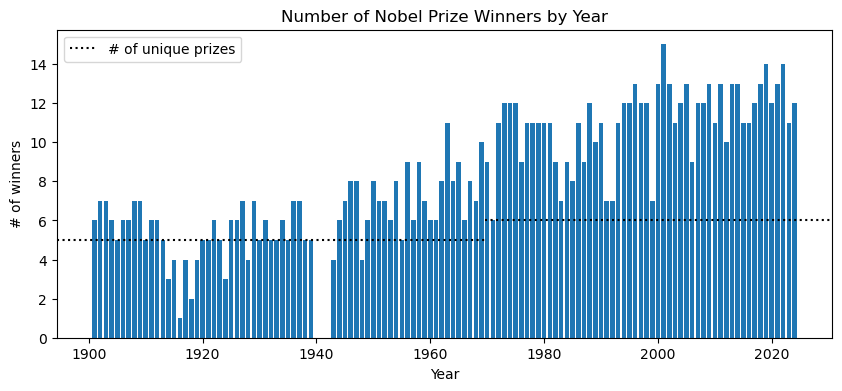

In [ ]:
plt.figure(figsize=(10,4))
first_year = min(winners_per_year.keys())
last_year = max(winners_per_year.keys())
# prize_added = (last_year-first_econ)/(last_year-first_year)
prize_added = (first_econ-first_year)/(last_year-first_year)
plt.bar(winners_per_year.keys(), winners_per_year.values())
plt.axhline(len(unique_prizes)-1, xmax=prize_added, c='k', ls=':', label='# of unique prizes')
plt.axhline(len(unique_prizes), xmin=prize_added, c='k', ls=':')
plt.title("Number of Nobel Prize Winners by Year");
plt.legend()
plt.xlabel("Year")
plt.ylabel("# of winners");

**🤔 Q: Do you notice anything interesting in the plot above?**

## Pandas DataFrame (preview)

Next, we parse the collected data and create a `pandas.DataFrame`. A DataFrame is like a table, where each row corresponds to a data entry and each column corresponds to a feature. Once we have a DataFrame, we can easily export it to our disk in CSV, JSON, or other formats.

The easiest way to create a DataFrame is to build a list of dictionaries.

Each entry in the list (a dictionary) is a data point, where keys are column names in the table. Let's see it in action.

In thise case, we'd actually like each row in the table to be a laureate, so we will construct a new list of laureate dictionaries from our exisitng list of prize dictionaries!

In [ ]:
laureate_dicts = []
for p in parsed_prizes:
    for l in p['laureates']:
        laureate_dicts.append({
            'name': l[0],
            'url': l[1],
            'year': p['year'],
            'prize': re.sub(r'(.*) \d{4}', r'\1', p['title']),
            'desc': p['description']
        })

In [ ]:
laureate_dicts[0]

{'name': 'John J. Hopfield',
 'url': 'https://www.nobelprize.org/prizes/physics/2024/hopfield/facts/',
 'year': 2024,
 'prize': 'Nobel Prize in Physics',
 'desc': '“for foundational discoveries and inventions that enable machine learning with artificial neural networks”'}

In [ ]:
df = pd.DataFrame(laureate_dicts)
df.head()

,name,url,year,prize,desc
0,John J. Hopfield,https://www.nobelprize.org/prizes/physics/2024...,2024,Nobel Prize in Physics,“for foundational discoveries and inventions t...
1,Geoffrey Hinton,https://www.nobelprize.org/prizes/physics/2024...,2024,Nobel Prize in Physics,“for foundational discoveries and inventions t...
2,David Baker,https://www.nobelprize.org/prizes/chemistry/20...,2024,Nobel Prize in Chemistry,“for computational protein design”
3,Demis Hassabis,https://www.nobelprize.org/prizes/chemistry/20...,2024,Nobel Prize in Chemistry,“for computational protein design”
4,John Jumper,https://www.nobelprize.org/prizes/chemistry/20...,2024,Nobel Prize in Chemistry,“for computational protein design”


Finally, we can save all of our work by writing our DataFrame to a csv file.

In [ ]:
df.to_csv('scraped_awards.csv', index=False)

Which can of course be loaded to reproduce our DataFrame!

In [ ]:
df_reloaded = pd.read_csv('scraped_awards.csv')
df_reloaded.head()

,name,url,year,prize,desc
0,John J. Hopfield,https://www.nobelprize.org/prizes/physics/2024...,2024,Nobel Prize in Physics,“for foundational discoveries and inventions t...
1,Geoffrey Hinton,https://www.nobelprize.org/prizes/physics/2024...,2024,Nobel Prize in Physics,“for foundational discoveries and inventions t...
2,David Baker,https://www.nobelprize.org/prizes/chemistry/20...,2024,Nobel Prize in Chemistry,“for computational protein design”
3,Demis Hassabis,https://www.nobelprize.org/prizes/chemistry/20...,2024,Nobel Prize in Chemistry,“for computational protein design”
4,John Jumper,https://www.nobelprize.org/prizes/chemistry/20...,2024,Nobel Prize in Chemistry,“for computational protein design”


## Appendix

### Async Requests with asyncio + httpx (Optional)

So far we fetched just **one page at a time** with `requests`.  
If we want to fetch **several pages** (like different Nobel Prize year ranges), it can get slow.

Python’s built-in **`asyncio`** lets us run many tasks *concurrently*.  
The library **`httpx`** works just like `requests`, but supports async.

- `asyncio` = the engine (already in Python).  
- `httpx` = the car (install with `pip install httpx`).  

Together, they let us fetch many pages **at once** instead of one by one.

### Step 1 — Setup

We’ll use:

- **`asyncio`** → built-in Python library for running tasks concurrently.  
- **`httpx`** → an HTTP client that supports async requests.  

In [ ]:
import asyncio
import httpx

### Step 2 — Define URLs to Fetch

The Nobel Prize site groups “All Nobel Prizes” pages by year ranges.  
We’ll build a small list of URLs to fetch concurrently.

In [ ]:
BASE = "https://www.nobelprize.org/prizes/lists/all-nobel-prizes/"
URLS = [
    BASE,                     # 2024–2020
    BASE + "2019-2010/",      # 2019–2010
    BASE + "2009-2000/",      # 2009–2000
    BASE + "1999-1990/",      # 1999–1990
]

### Step 3 — Write Async Helpers

We’ll build small helper functions to actually fetch pages.

#### Part A — `fetch_one`
This is the *basic worker*:
- It fetches **one URL** using `httpx`.
- If successful, it returns `(url, length_of_page)`.
- If it fails (timeout, error), it prints a message and returns `(url, 0)`.

This keeps the rest of our code simple.

In [ ]:
async def fetch_one(client, url):
    try:
        r = await client.get(url, timeout=10.0)
        r.raise_for_status()         # raise error if not 200 OK
        return url, len(r.text)      # return url + page length
    except Exception as e:
        print(f"[Error] {url} -> {e}")
        return url, 0


#### Part B — Two ways to fetch MANY pages

Now we want to fetch multiple URLs.  
There are **two options**:

1. **Semaphore approach** (*rolling window*):  
   - At most N requests at the same time.  
   - As soon as one finishes, another can start.  
   - Great for being polite to the server.

2. **Batching approach** (*fixed groups*):  
   - Send a batch of N requests at once.  
   - Then wait a short delay before the next batch.  
   - Useful if the site has a rule like “max 5 calls per second.”

In [ ]:
# Option 1: Semaphore (rolling window)
async def fetch_many_semaphore(urls, max_concurrency=5):
    sem = asyncio.Semaphore(max_concurrency)   # gatekeeper
    async with httpx.AsyncClient() as client:
        async def bound_fetch(url):
            async with sem:    # only N requests in flight
                return await fetch_one(client, url)
        return await asyncio.gather(*(bound_fetch(u) for u in urls))

# Option 2: Batching (rate-limited groups)
async def fetch_many_batches(urls, batch_size=5, delay=1.0):
    results = []
    async with httpx.AsyncClient() as client:
        for i in range(0, len(urls), batch_size):
            batch = urls[i:i+batch_size]

            # Build a list of coroutine objects (one per URL)
            tasks = [fetch_one(client, u) for u in batch]

            # asyncio.gather expects *separate arguments* (coro1, coro2, ...)
            # If we just wrote asyncio.gather(tasks), it would see ONE argument (a list)
            # By writing *tasks, we unpack the list into separate args
            batch_results = await asyncio.gather(*tasks)

            results.extend(batch_results)

            # Pause before starting the next batch (to respect rate limits)
            if i + batch_size < len(urls):
                await asyncio.sleep(delay)
    return results

### Step 4 — Run the Async Fetch

Now let’s actually fetch the pages.

We’ll try **both options** from Step 3:

1. **Semaphore (rolling window)** → at most N requests in flight at once.  
2. **Batching (rate-limited groups)** → groups of N requests, then wait a moment.  

We’ll print out the URL and the page length for each result.

In [ ]:
print("=== Option 1: Semaphore (rolling window) ===")
results1 = await fetch_many_semaphore(URLS, max_concurrency=2)
for url, length in results1:
    print(url, "-> length:", length)

print("\n=== Option 2: Batching (fixed groups) ===")
results2 = await fetch_many_batches(URLS, batch_size=2, delay=1.0)
for url, length in results2:
    print(url, "-> length:", length)

=== Option 1: Semaphore (rolling window) ===
https://www.nobelprize.org/prizes/lists/all-nobel-prizes/ -> length: 159859
https://www.nobelprize.org/prizes/lists/all-nobel-prizes/2019-2010/ -> length: 184068
https://www.nobelprize.org/prizes/lists/all-nobel-prizes/2009-2000/ -> length: 187112
https://www.nobelprize.org/prizes/lists/all-nobel-prizes/1999-1990/ -> length: 182236

=== Option 2: Batching (fixed groups) ===
https://www.nobelprize.org/prizes/lists/all-nobel-prizes/ -> length: 159859
https://www.nobelprize.org/prizes/lists/all-nobel-prizes/2019-2010/ -> length: 184068
https://www.nobelprize.org/prizes/lists/all-nobel-prizes/2009-2000/ -> length: 187112
https://www.nobelprize.org/prizes/lists/all-nobel-prizes/1999-1990/ -> length: 182236


🌈 **The End**